# Trying out an LDA model to apply topic modelling to MEAs

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
# Handle imports
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pickle
from gensim.models import CoherenceModel
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pprint
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm_notebook as tqdm

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
nlp = spacy.load('en_core_web_lg')
lemmatizer = nlp.get_pipe("lemmatizer")

In [159]:
l1 = ["charge", "responsibility", "enforce", "broker", "codify", "find", "order", "necessary", "appropriate", "consistent", "purpose", "broker", "return", "business", "address", "record", "serve", "mail", "broker", "certificate", "registration", "right", "hearing", "matter", "notify", "mail", "request", "hearing", "date", "mailing"]
set(l1)

{'address',
 'appropriate',
 'broker',
 'business',
 'certificate',
 'charge',
 'codify',
 'consistent',
 'date',
 'enforce',
 'find',
 'hearing',
 'mail',
 'mailing',
 'matter',
 'necessary',
 'notify',
 'order',
 'purpose',
 'record',
 'registration',
 'request',
 'responsibility',
 'return',
 'right',
 'serve'}

In [215]:
stop_word_list = ["transcript","respondent","ohio","division", "department", "commerce","financial","revised","code","institutions","chapter","codified","institution","heshe","rc","oh","mortgage","fact","notice","act","chapters","arizona","january","february","april","march","may","june","july","august","september","october","november","december","dfi","ce","pursuant","realize","days","result","investigation","indicate","state",'address',
 'appropriate',
 'broker',
 'business',
 'certificate',
 'charge',
 'codify',
 'consistent',
 'date',
 'enforce',
 'find',
 'hearing',
 'mail',
 'mailing',
 'matter',
 'necessary',
 'notify',
 'order',
 'purpose',
 'record',
 'registration',
 'request',
 'responsibility',
 'return',
 'right',
 'serve',
 'loan', 
 'officer',
 'application',
 'background', 'come', 'attorney', 'law', 'duly', 'appoint', 'accordance', 'revise', 'administrative','detailed','paragraph','page','exhibit']

In [216]:
len(stop_word_list)

85

In [203]:
nlp.Defaults.stop_words.update(stop_word_list)
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
lemma_tags = {"NNS", "NNPS"}

In [204]:
# Load data
df = pd.read_csv("Standardized Data/Final_cleaned.csv")

In [205]:
def clean_text(sample_text):
    sample_text = sample_text.translate(str.maketrans('', '', string.punctuation))
    sample_text = " ".join([w for w in sample_text.split() if not w.isdigit()])
    sample_text = sample_text.lower()
    doc = nlp(sample_text)
    doc = [token.lemma_ for token in doc if (token.tag_ in lemma_tags or token.lemma_ != '-PRON-' and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])]
    doc = u' '.join(doc)
    doc = nlp.make_doc(doc)
    tokens = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return tokens

In [206]:
sample_text = df.loc[1873,"Text"]
print(clean_text(sample_text))
print(len(clean_text(sample_text)))

['license', 'practice', 'procedure', 'hold', 'south', 'hold', 'meister', 'consider', 'allegation', 'intent', 'deny', 'license', 'opportunity', 'hear', 'allege', 'convict', 'count', 'attempt', 'pass', 'bad', 'check', 'fail', 'disclose', 'conviction', 'file', 'assert', 'eligible', 'license', 'following', 'reason', 'prove', 'honest', 'truthful', 'good', 'reputation', 'basis', 'believe', 'commit', 'offense', 'require', 'character', 'general', 'fitness', 'command', 'confidence', 'public', 'warrant', 'belief', 'operate', 'honestly', 'fairly', 'compliance', 'require', 'fail', 'disclose', 'criminal', 'conviction', 'fail', 'comply', 'b', 'require', 'assistant', 'general', 'executive', 'agency', 'section', 'office', 'general', 'represent', 'appear', 'explanation', 'absence', 'exhibit', 'admit', 'jurisdiction', 'procedural', 'issue', 'certify', 'receipt', 'exhibit', 'receive', 'exhibit', 'schedule', 'time', 'location', 'send', 'ordinary', 'exhibit', 'file', 'exhibit', 'question', 'ask', 'follow',

In [191]:
sample_text

" A. Background This matter came before James J. Lawrence, an attorney licensed to practice law in the state of Ohio and duly appointed by the Ohio Division of Financial Institutions (Division) to serve as Hearing Officer for this hearing in accordance with Ohio Revised Code (R.C.) Chapter 119, the Administrative Procedure Act. The hearing was held at 10:00 a.m. on April 19, 2005, at 77 South High Street, Columbus, Ohio. The hearing was held at the request of Respondent Christopher H. B. Meister (Respondent) to consider the allegations in the Division's Notice of Intent to Deny Loan Officer License Application and Notice of Opportunity for Hearing (NOH). The Division alleges that Respondent was convicted of two counts of attempting passing bad checks in 2002 and failed to disclose the convictions on his loan officer application filed in August of 2004. Therefore, the Division asserts that Respondent is not eligible for a loan officer license pursuant to the Ohio Mortgage Broker Act, R.

In [17]:
from transformers import pipeline
summarizer = pipeline("summarization")
summarizer(sample_text, max_length=200, min_length=30, do_sample=False)

[{'summary_text': ' The Ohio Department of Commerce is charged with enforcing the Ohio Mortgage Broker Act, codified in Ohio Revised Code (R.C.) Chapter 1322) The Division of Financial Institutions (the Division) finds that this Order is necessary and or appropriate, in the public interest .'}]

In [192]:
text = df["Text"]
text_list = []
for doc in tqdm(text):
    if not pd.isna(doc):
        pr = clean_text(doc)
        text_list.append(pr)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/6041 [00:00<?, ?it/s]

In [64]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_list, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text_list], threshold=30) 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example

print(trigram_mod[bigram_mod[text_list[1]]])

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['charge_responsibility', 'enforce', 'broker', 'codify', 'revise', 'responsibility', 'protect', 'public', 'proscribe', 'practice', 'find', 'order_necessary_appropriate', 'public', 'interest', 'consistent', 'purpose', 'broker', 'send', 'certify_mail', 'intent', 'revoke', 'certificate', 'registration', 'opportunity', 'hear', 'crew', 'funding', 'business', 'address', 'record', 'hold', 'hearing', 'matter', 'accordance', 'daysjuly', 'hearing', 'officer', 'issue', 'report', 'recommendation', 'determine', 'crew', 'funding', 'violate', 'list', 'fictitious', 'creditor', 'false', 'information', 'loan', 'document', 'convert', 'borrower', 'creditor', 'money', 'cause', 'customer', 'sign_blank', 'loan', 'document', 'charge', 'excess', 'fee', 'interfere', 'crew', 'funding', 'order', 'page', 'hearing', 'officer', 'report', 'recommend', 'superintendent', 'revoke', 'broker', 'certificate', 'registration', 'file', 'objection', 'hearing', 'officer', 'report', 'recommendation', 'carefully', 'consider', 'he

In [65]:
grammed_list = [trigram_mod[bigram_mod[doc]]for doc in text_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [193]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(text_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in text_list]

In [67]:
# Creates, which is a mapping of word IDs to words.
grammed_words = corpora.Dictionary(grammed_list)

# Turns each document into a bag of words.
grammed_corpus = [words.doc2bow(doc) for doc in grammed_list]

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [195]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=words, random_state = 12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=19, id2word=words, random_state = 12)

In [196]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=text_list, start=18, limit=25, step=1)

In [134]:
# Can take a long time to run.
grammed_model_list, grammed_coherence_values = compute_coherence_values(dictionary=grammed_words, corpus=grammed_corpus, texts=grammed_list, start=18, limit=25, step=1)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
import tomotopy as tp
import numpy as np

term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 7, gamma = 1, alpha = 0.1,initial_k = 10, seed = 12)

In [220]:
sum = 0
for text in text_list:
    if len(text) > 0:
        hdp.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
      ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

0
Num docs: 5596 , Vocab size: 2626 , Num words: 524316
Removed top words: ['license', 'fail', 'deny', 'applicant', 'require', 'issue', 'page']
Iteration: 0	Log-likelihood: -5.424908263127247	Num. of topics: 20
Iteration: 100	Log-likelihood: -5.4145186110545565	Num. of topics: 21
Iteration: 200	Log-likelihood: -5.410201115542335	Num. of topics: 21
Iteration: 300	Log-likelihood: -5.409823781417472	Num. of topics: 21
Iteration: 400	Log-likelihood: -5.408504290534877	Num. of topics: 22
Iteration: 500	Log-likelihood: -5.407774265510615	Num. of topics: 20
Iteration: 600	Log-likelihood: -5.407088430357502	Num. of topics: 21
Iteration: 700	Log-likelihood: -5.407022666399672	Num. of topics: 22
Iteration: 800	Log-likelihood: -5.4071347396601235	Num. of topics: 22
Iteration: 900	Log-likelihood: -5.407152160358158	Num. of topics: 21


In [131]:
term_weight = tp.TermWeight.ONE
hdp_gram = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 7, gamma = 1, alpha = 0.1,initial_k = 10, seed = 12)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
sum = 0
for text in grammed_list:
    if len(text) > 0:
        hdp_gram.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp_gram.burn_in = 100
hdp_gram.train(0)
print('Num docs:', len(hdp_gram.docs), ', Vocab size:', hdp_gram.num_vocabs,
      ', Num words:', hdp_gram.num_words)
print('Removed top words:', hdp_gram.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp_gram.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp_gram.ll_per_word, hdp_gram.live_k))

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
Num docs: 5596 , Vocab size: 3609 , Num words: 525801
Removed top words: ['loan', 'officer', 'license', 'application', 'hearing', 'fail', 'deny']
Iteration: 0	Log-likelihood: -5.440105475753123	Num. of topics: 23
Iteration: 100	Log-likelihood: -5.43156534654541	Num. of topics: 23
Iteration: 200	Log-likelihood: -5.427888941099954	Num. of topics: 23
Iteration: 300	Log-likelihood: -5.426786755578517	Num. of topics: 25
Iteration: 400	Log-likelihood: -5.427086953384736	Num. of topics: 24
Iteration: 500	Log-likelihood: -5.425923427824316	Num. of topics: 25
Iteration: 600	Log-likelihood: -5.426840598779457	Num. of topics: 24
Iteration: 700	Log-likelihood: -5.426455026874063	Num. of topics: 24
Iteration: 800	Log-likelihood: -5.4272274290496405	Num. of topics: 25
Iteration: 900	Log-likelihood: -5.4266974182563805	Num. of topics: 24


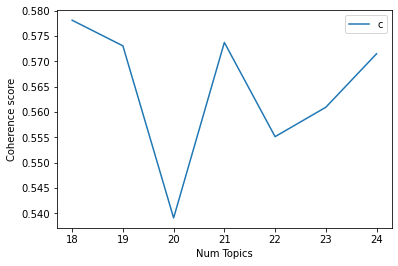

In [197]:
# Show graph
limit=25; start=18; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [198]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.5782
Num Topics = 19  has Coherence Value of 0.5731
Num Topics = 20  has Coherence Value of 0.5391
Num Topics = 21  has Coherence Value of 0.5738
Num Topics = 22  has Coherence Value of 0.5551
Num Topics = 23  has Coherence Value of 0.5609
Num Topics = 24  has Coherence Value of 0.5715


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


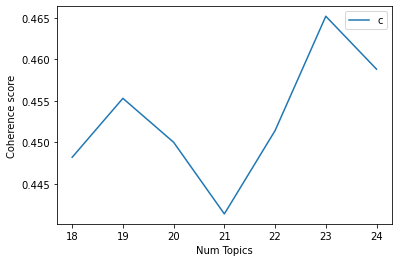

In [137]:
# Show graph
limit=25; start=18; step=1;
x = range(start, limit, step)
plt.plot(x, grammed_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [138]:
# Print the coherence scores
for m, cv in zip(x, grammed_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.4482
Num Topics = 19  has Coherence Value of 0.4553
Num Topics = 20  has Coherence Value of 0.45
Num Topics = 21  has Coherence Value of 0.4414
Num Topics = 22  has Coherence Value of 0.4514
Num Topics = 23  has Coherence Value of 0.4652
Num Topics = 24  has Coherence Value of 0.4588


/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [199]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_list[1], corpus, words)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.195682 -0.067828       1        1  15.411364
5     -0.220754  0.175074       2        1  12.929058
13    -0.161703  0.071799       3        1   8.255491
12    -0.242175 -0.167744       4        1   7.476296
4      0.067200  0.041372       5        1   7.270224
6      0.017376 -0.176998       6        1   6.269756
7      0.002599 -0.075210       7        1   5.788625
8      0.029548  0.101492       8        1   5.300605
14     0.115294 -0.021269       9        1   5.082865
16     0.103578  0.030416      10        1   4.678023
11     0.099467 -0.080629      11        1   3.580703
9      0.001981  0.066904      12        1   3.535848
0      0.104875 -0.055997      13        1   3.198816
15    -0.013342  0.004403      14        1   3.109328
10     0.053148  0.095985      15        1   2.833205
1     -0.073821  0.186268      16        1   1.612612
18     0.157782  0.008127      17        1   1.596924
2     -0.263499 -0.153418      18        1   1.555728
3      0.026765  0.017253      19        1   0.514529, topic_info=            Term          Freq         Total Category  logprob  loglift
189      license  23810.000000  23810.000000  Default  30.0000  30.0000
410      renewal   6273.000000   6273.000000  Default  29.0000  29.0000
173       intent   3700.000000   3700.000000  Default  28.0000  28.0000
296       report   4732.000000   4732.000000  Default  27.0000  27.0000
95          deny   7740.000000   7740.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
677    applicant     43.309398   8441.054991  Topic19  -4.2706  -0.0028
430      command     26.538265   2783.290279  Topic19  -4.7604   0.6169
309         rule     22.896771   1738.797527  Topic19  -4.9080   0.9397
219  opportunity     24.736110   3587.870357  Topic19  -4.8307   0.2926
671      require     26.174539   7263.257478  Topic19  -4.7742  -0.3561

[1312 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1507      1  0.542213  00crb0115611
657       5  0.891608      132202a1
657       6  0.068585      132202a1
3803      1  0.075108       132203b
3803     11  0.075108       132203b
...     ...       ...           ...
380      16  0.006714          year
380      17  0.003443          year
380      18  0.002927          year
380      19  0.002755          year
1591      6  0.818006       yohance

[7313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 6, 14, 13, 5, 7, 8, 9, 15, 17, 12, 10, 1, 16, 11, 2, 19, 3, 4])

In [140]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(grammed_model_list[5], corpus, words)

/opt/anaconda3/envs/APL2021_DataPlus/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.084768  0.108554       1        1  13.451544
1     -0.121727 -0.006278       2        1  10.466391
21     0.014681  0.060778       3        1   9.317717
6     -0.260481 -0.089273       4        1   8.342087
22    -0.343632 -0.060684       5        1   8.087177
12     0.007749 -0.096651       6        1   6.661994
10     0.010272  0.091640       7        1   6.618141
19     0.004301  0.141706       8        1   4.828786
13    -0.026089  0.088944       9        1   4.193087
20    -0.018634  0.188159      10        1   4.059817
15     0.043621  0.189110      11        1   3.951543
5      0.190362 -0.174791      12        1   3.649781
14     0.084271  0.008519      13        1   3.095457
9      0.076391 -0.080125      14        1   3.045900
4      0.080841 -0.164757      15        1   2.086005
16    -0.131770 -0.109390      16        1   1.789102
11    -0.053038 -0.054913      17        1   1.759118
7     -0.072927 -0.007170      18        1   1.444861
2      0.006652 -0.020822      19        1   1.081467
0     -0.009283  0.108313      20        1   1.064392
18     0.179447 -0.107452      21        1   0.872772
17     0.145175 -0.059664      22        1   0.092650
3      0.109051  0.046247      23        1   0.040211, topic_info=          Term          Freq         Total Category  logprob  loglift
239    officer  31155.000000  31155.000000  Default  30.0000  30.0000
213       loan  34383.000000  34383.000000  Default  29.0000  29.0000
715  applicant   8950.000000   8950.000000  Default  28.0000  28.0000
207    license  26779.000000  26779.000000  Default  27.0000  27.0000
138    exhibit   8512.000000   8512.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
211       list      1.472473   5685.875950  Topic23  -5.3570  -0.4400
715  applicant      1.583411   8950.031565  Topic23  -5.2844  -0.8211
57    business      1.489331   6676.356530  Topic23  -5.3456  -0.5892
709    require      1.506200   8160.253861  Topic23  -5.3344  -0.7787
56      broker      1.415711   6525.313305  Topic23  -5.3963  -0.6170

[1548 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1545      6  0.615949  00crb0115611
453      15  0.584592       132153b
695      12  0.367712      132202a1
695      14  0.551568      132202a1
766      12  0.146908      1322031a
...     ...       ...           ...
406      21  0.000454          year
406      22  0.000151          year
406      23  0.000151          year
3871     19  0.321899        yellow
1629      6  0.823129       yohance

[7406 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 22, 7, 23, 13, 11, 20, 14, 21, 16, 6, 15, 10, 5, 17, 12, 8, 3, 1, 19, 18, 4])

In [23]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [207]:
def format_topics_sentences(ldamodel=model_list[1], corpus=corpus, texts=text_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[1], corpus=corpus, texts=text_list)

In [213]:
df_topic_sents_keywords["Dominant_Topic"] = df_topic_sents_keywords["Dominant_Topic"].apply(lambda x: mapping[x])

In [214]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16,0.6374,"violate, license, list, statement, paragraph, action, buyer, borrower, page, fee","[abovecaptione, license, practice, procedure, commence, office, south, high, floor, hold, close, day, hold, follow, funding, hereinafter, crew, consider, intent, revoke, inter, alia, base, engage, improper, fraudulent, dishonest, activity, appear, hereinafter, represent, general, general, appear, represent, jurisdiction, issue, intent, deny, opportunity, hereinafter, refer, case, 01mb11, service, perfect, timely, schedule, requirement, orc, exhibit, continue, original, counsel, continue, new, counsel, continue, forward, posthearing, ruling, exhibit, offer, remain, rule, page, exhibit, 3h, letter, apparently, sign, crew, letterhead, letter, white, testimony, p, testimony, letter, examination, additional, testimony, include, testimony, opposition, offer, leave, determine, admission, admit, use, weight, document, exhibit, 3h, appear, belong, witness, appear, similarity, ...]"
1,1,16,0.5733,"violate, license, list, statement, paragraph, action, buyer, borrower, page, fee","[protect, public, proscribe, practice, public, interest, send, certify, intent, revoke, opportunity, hear, crew, funding, hold, daysjuly, issue, report, recommendation, determine, crew, funding, violate, list, fictitious, creditor, false, information, document, convert, borrower, creditor, money, cause, customer, sign, blank, document, excess, fee, interfere, crew, funding, page, report, recommend, superintendent, revoke, file, objection, report, recommendation, carefully, consider, report, recommendation, objection, thereto, reject, objection, confirm, approve, report, recommendation, previously, issue, crew, funding, revoke]"
2,2,10,0.3117,"fine, violation, dollar, registrant, revoke, conduct, provide, superintendent, license, issue","[protect, public, proscribe, lending, practice, interest, public, specialists, corporation, renew, period, certify, intent, revoke, entitle, adjudicative, day, day, issue, revoke, specialists, specialists, page, fail, fail, defend, allegation, violate, substantial, misrepresentation, renewal, obtain, false, fraudulent, representation, allegation, contain, true, revoke]"
3,3,10,0.5408,"fine, violation, dollar, registrant, revoke, conduct, provide, superintendent, license, issue","[protect, public, proscribe, lending, practice, interest, public, funding, corporation, register, lender, fail, renew, period, begin, east, certify, intent, revoke, lender, entitle, adjudicative, day, day, issue, revoke, lender, page, fail, fail, defend, allegation, meet, net, worth, requirement, mandate, 132153b, allegation, contain, true, lender, revoke]"
4,4,10,0.7159,"fine, violation, dollar, registrant, revoke, conduct, provide, superintendent, license, issue","[protect, public, proscribe, lending, practice, interest, public, regional, acceptance, finance, corporation, corporation, hold, active, lender, certify, intent, revoke, lender, entitle, adjudicative, day, day, issue, revoke, lender, regional, acceptance, finance, corporation, fail, fail, defend, allegation, meet, net, worth, requirement, mandate, 132153b, regional, finance, corporation, page, allegation, contain, true, lender, regional, acceptance, finance, corporation, revoke]"
...,...,...,...,...,...
5632,5632,2,0.6486,"license, applicant, fail, settlement, agreement, require, calendar, year, omba, complete","[settlement, agreement, enter, basis, following, stipulation, admission, understanding, empower, refuse, renew, second, lender, applicant, default, payment, annual, fee, prescribe, community, require, submit, renewal, annual, fee, community, submit, renewal, remain, pende, community, understand, timely, submit, renewal, authority, refuse, renew, community, omla, enter, settlement, agreement, lieu, formal, proceeding, deny, community, renewal, basis, untimely, filing, expressly, reserve, institute, formal, proceeding, base, violat

In [209]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9935,"license, violate, fitness, list, character, operate, command, honestly, public, confidence","[conduct, follow, failure, comply, continue, education, requirement, fail, disclose, information, concern, license, renewal, refusal, character, general, fitness, command, confidence, public, warrant, belief, operate, honestly, fairly, compliance, fail, disclose, information, concern, license, renewal, refusal, violate, prohibit, applicant, substantial, misrepresentation, license, c, fail, disclose, information, concern, license, renewal, refusal, violate, prohibit, applicant, false, misleading, statement, material, omission, statement, require, fail, disclose, information, concern, license, renewal, refusal, violate, intent, deny, license, opportunity, hear, page, prohibit, applicant, engage, conduct, constitute, improper, fraudulent, dishonest, dealing, finding, list, determine, action, list, paragraph, character, general, fitness, command, confidence, public, warrant, belief, operate, honestly, fairly, compliance, action, list, ...]"
1,1.0,0.9073,"operation, manager, impose, registrant, designate, fail, section, examination, individual, violation","[conduct, follow, authorize, impose, fine, registrant, dollar, day, violation, rule, commit, repeat, continue, require, applicant, limited, liability, company, designate, operation, manager, c, person, designate, operation, manager, long, operation, manager, registrant, designate, person, operation, manager, day, day, thereof, writing, designation, section, intent, fine, opportunity, hear, page, receive, change, operation, manager, operation, manager, cease, operation, manager, designate, paeltz, propose, operation, manager, prior, receive, notification, departure, designation, paeltz, propose, operation, manager, e, operate, registrant, designate, andor, approve, operation, manager, violation, oac, finding, list, determine, violate, authority, impose, fine, fine, dollar, reasonable]"
2,2.0,0.9763,"intent, license, renewal, deny, terminate, issue, superintendent, termination, moot, requirement","[drive, termination, intent, deny, renewal, license, superintendent, issue, intent, deny, renewal, license, license, submit, check, renewal, issue, deny, renewal, license, prior, issue, receive, check, intent, deny, renewal, license, base, failure, submit, check, moot, supersede, terminate, intent, deny, license, renewal, appellate]"
3,3.0,0.5848,"license, fail, comply, conduct, violate, section, condition, page, applicant, refuse","[conduct, follow, authorize, refuse, renew, license, licensee, violate, fail, comply, provision, section, rule, adopt, section, applicable, conduct, provide, license, renew, annually, superintendent, applicant, meet, condition, set, a2, provide, license, issue, applicant, character, general, fitness, command, confidence, public, warrant, belief, operate, honestly, fairly, compliance, section, opportunity, hear, page, determination, character, general, fitness, superintendent, consider, applicant, fail, fully, satisfy, judgment, award, issue, court, competent, jurisdiction, fine, impose, federal, regulatory, body, e, county, common, plea, court, case, case, cv, final, judgment, enter, favor, plaintiff, cost, interest, judgment, enter, relate, judgment, enter, case, cv04542704, submit, license, renewal, disclose, civil, judgment, enter, provide, statement, satisfy, ...]"
4,4.0,0.9345,"exhibit, license, originator, tr, testimony, letter, conviction, receive, fail, general","[license, practice, procedure, hold, pm, south, hold, p, voll, consider, allegation, intent, deny, license, opportunity, hear, allege, convict, theft, theft, forgery, fail, disclose, conviction, file, assert, eligible, license, follow, reason, prove, honest, truthful, good, reputation, basis, believe, commit, criminal, offense, involve, theft, criminal, offense, involve, money, security, require, character, general, fitness, command, confidence,

In [210]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts.head()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Num_Documents,Perc_Documents
17.0,1019,0.1808
5.0,914,0.1621
13.0,657,0.1166
12.0,566,0.1004
7.0,464,0.0823
6.0,372,0.0660
2.0,318,0.0564
11.0,221,0.0392
14.0,184,0.0326
9.0,164,0.0291


In [211]:
df_dominant_topics.sort_values(by = ["Num_Documents"],ascending = False, inplace = True)
df_dominant_topics["Old Index"] = df_dominant_topics.index 
df_dominant_topics.reset_index(inplace = True)
mapping = df_dominant_topics[["Old Index"]].to_dict()['Old Index']
mapping = {value : key+1 for (key, value) in mapping.items()}
mapping

{17.0: 1,
 5.0: 2,
 13.0: 3,
 12.0: 4,
 7.0: 5,
 6.0: 6,
 2.0: 7,
 11.0: 8,
 14.0: 9,
 9.0: 10,
 15.0: 11,
 16.0: 12,
 0.0: 13,
 4.0: 14,
 8.0: 15,
 10.0: 16,
 18.0: 17,
 1.0: 18,
 3.0: 19}